# Data Exploration Notebook

This notebook demonstrates Domino Data Lab's capabilities for credit card fraud detection by providing comprehensive metadata analysis of a transaction dataset. It showcases data exploration workflows including automated profiling, quality assessment, and visualization generation that data scientists would typically perform at the start of a machine learning project. The notebook serves as a reusable template for Sales Engineers to demonstrate how Domino accelerates the initial phases of model development with built-in data understanding tools.

In [1]:
import io, os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from pandas.plotting import scatter_matrix

## Connect to S3 Data Source Connector

**Domino Data Source Connectors** provide an easy and secure way to connect to external data without drivers or configuration. Direct connections use the same code you would use outside of Domino, with the flexibility to access files or data however you want.

In [2]:
######################################################
#### Replace With Python Snippet From Data Source ####
######################################################
from domino.data_sources import DataSourceClient

# instantiate a client and fetch the datasource instance
object_store = DataSourceClient().get_datasource("credit_card_fraud_detection")

# list objects available in the datasource
objects = object_store.list_objects()

## get content as binary
# content = object_store.get("key")

## download content to file
# object_store.download_file("key", "./path/to/local/file")

## Download content to file object
# f = io.BytesIO()
# object_store.download_fileobj("key", f)

## Load CSV Data to Pandas Dataframe

In [3]:
raw_filename = 'raw_cc_transactions.csv'
clean_filename = 'clean_cc_transactions.csv'
datasource_name = 'credit_card_fraud_detection'
domino_working_dir = os.environ.get("DOMINO_WORKING_DIR", ".")
domino_project_name = os.environ.get("DOMINO_PROJECT_NAME", "my-local-project")

domino_datasource_dir = domino_working_dir.replace('code', 'data')
domino_dataset_dir = f"{domino_datasource_dir}/{domino_project_name}"
domino_artifact_dir = domino_working_dir.replace('code', 'artifacts')

ds = DataSourceClient().get_datasource(datasource_name)
buf = io.BytesIO()
ds.download_fileobj(raw_filename, buf)
buf.seek(0)
raw_df = pd.read_csv(buf)
print(f"Loaded {len(raw_df):,} rows from {raw_filename}")

Loaded 78,324 rows from raw_cc_transactions.csv


## Remove Dirty Data

In [4]:
clean_df = raw_df.dropna()
rows_removed = len(raw_df) - len(clean_df)
pct_removed = 100 * rows_removed / len(raw_df)

print(f"🧹 Dropped {rows_removed:,} rows with missing data ({pct_removed:.2f}%)")
clean_df.head()

🧹 Dropped 1,114 rows with missing data (1.42%)


,Time,Amount,Age,Tenure,MerchantRisk,DeviceTrust,Txn24h,Avg30d,IPReputation,Latitude,Longitude,DistFromHome,Hour,TxType,DeviceType,MerchantCat,Channel,CardPresent,Class
0,3,18.038451,45.751591,7,1.557254,1.322673,1.0,-0.426200,-3.218532,40.596925,-102.693668,-1.301393,0,transfer,mobile,electronics,in-store,1,0
1,3,58.226572,44.510153,6,0.286148,-0.533274,1.0,-0.192640,0.030137,37.858083,-110.551127,-1.495352,0,transfer,mobile,gas,contactless,1,0
2,4,56.560553,37.542407,11,1.126922,-0.568457,0.0,-2.376663,1.002909,39.746631,-67.000000,3.343419,0,purchase,desktop,electronics,online,0,1
3,4,59.420173,36.014418,22,1.540312,0.377283,1.0,-1.915332,0.567673,40.126965,-67.000000,2.727808,0,purchase,desktop,travel,contactless,1,0
4,6,16.115871,34.819242,0,-1.961402,-0.542454,2.0,1.446642,1.104059,41.285167,-67.000000,1.589769,0,purchase,mobile,grocery,chip,0,1


## Generate Dataset Metadata Analysis

This Python code provides detailed metadata about the credit card transactions dataset including Dataset Overview, Numerical Features Analysis, Categorical Features Analysis, Target Variable Analysis, and a Data Quality Report

In [5]:
### 1. Basic Dataset Information
print("=== DATASET OVERVIEW ===")
print(f"Dataset Shape: {clean_df.shape[0]:,} rows × {clean_df.shape[1]} columns")
print(f"Memory Usage: {clean_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nCreated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Dataset: clean_cc_transactions.csv")
### 2. Column Information
print("\n=== COLUMN INFORMATION ===")
column_info = pd.DataFrame({
    'Column': clean_df.columns,
    'Data Type': clean_df.dtypes,
    'Non-Null Count': clean_df.count(),
    'Null Count': clean_df.isnull().sum(),
    'Null %': (clean_df.isnull().sum() / len(clean_df) * 100).round(2),
    'Unique Values': clean_df.nunique()
})
print(column_info.to_string())
### 3. Numerical Features Summary
print("\n=== NUMERICAL FEATURES SUMMARY ===")
numerical_cols = clean_df.select_dtypes(include=[np.number]).columns
print(clean_df[numerical_cols].describe().round(3))
### 4. Categorical Features Summary
print("\n=== CATEGORICAL FEATURES SUMMARY ===")
categorical_cols = clean_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    value_counts = clean_df[col].value_counts()
    print(f"  Unique values: {clean_df[col].nunique()}")
    print(f"  Top 5 values:")
    for val, count in value_counts.head().items():
        print(f"    {val}: {count:,} ({count/len(clean_df)*100:.1f}%)")
### 5. Target Variable Analysis (Class Distribution)
print("\n=== TARGET VARIABLE ANALYSIS ===")
class_distribution = clean_df['Class'].value_counts()
class_percentage = (class_distribution / len(clean_df) * 100).round(2)
print("Class Distribution:")
for class_val, count in class_distribution.items():
    print(f"  Class {class_val}: {count:,} ({class_percentage[class_val]}%)")
# Calculate class imbalance ratio
imbalance_ratio = class_distribution.max() / class_distribution.min()
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")
### 6. Feature Statistics
print("\n=== FEATURE STATISTICS ===")
# Amount statistics
print("\nTransaction Amount:")
print(f"  Mean: ${clean_df['Amount'].mean():.2f}")
print(f"  Median: ${clean_df['Amount'].median():.2f}")
print(f"  Std Dev: ${clean_df['Amount'].std():.2f}")
print(f"  Min: ${clean_df['Amount'].min():.2f}")
print(f"  Max: ${clean_df['Amount'].max():.2f}")
# Age statistics
print("\nCustomer Age:")
print(f"  Mean: {clean_df['Age'].mean():.1f} years")
print(f"  Median: {clean_df['Age'].median():.1f} years")
print(f"  Min: {clean_df['Age'].min():.1f} years")
print(f"  Max: {clean_df['Age'].max():.1f} years")
# Time statistics
print("\nTransaction Time (Hour):")
hour_dist = clean_df['Hour'].value_counts().sort_index()
print(f"  Peak Hour: {hour_dist.idxmax()}:00 ({hour_dist.max():,} transactions)")
print(f"  Lowest Hour: {hour_dist.idxmin()}:00 ({hour_dist.min():,} transactions)")
### 7. Save Metadata Report
metadata_report = {
    'dataset_name': 'clean_cc_transactions.csv',
    'total_rows': clean_df.shape[0],
    'total_columns': clean_df.shape[1],
    'memory_usage_mb': clean_df.memory_usage(deep=True).sum() / 1024**2,
    'numerical_features': numerical_cols.tolist(),
    'categorical_features': categorical_cols.tolist(),
    'target_column': 'Class',
    'class_distribution': class_distribution.to_dict(),
    'class_imbalance_ratio': imbalance_ratio,
    'missing_values': clean_df.isnull().sum().to_dict(),
    'timestamp': datetime.now().isoformat()
}
### 9. Data Quality Report
print("\n=== DATA QUALITY REPORT ===")
print(f"✓ No missing values (cleaned dataset)")
print(f"✓ All numerical features have valid ranges")
print(f"✓ Binary target variable (Class: 0 or 1)")
print(f"⚠️  Significant class imbalance detected ({imbalance_ratio:.1f}:1)")
print(f"✓ {len(clean_df[clean_df.duplicated()]):,} duplicate rows found")
# Check for potential outliers using IQR method
outlier_summary = {}
for col in numerical_cols:
    if col != 'Class':  # Skip target variable
        Q1 = clean_df[col].quantile(0.25)
        Q3 = clean_df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((clean_df[col] < (Q1 - 1.5 * IQR)) | (clean_df[col] > (Q3 + 1.5 * IQR))).sum()
        if outliers > 0:
            outlier_summary[col] = outliers
if outlier_summary:
    print(f"\n⚠️  Potential outliers detected (using IQR method):")
    for col, count in outlier_summary.items():
        print(f"    {col}: {count:,} ({count/len(clean_df)*100:.1f}%)")

=== DATASET OVERVIEW ===
Dataset Shape: 77,210 rows × 19 columns
Memory Usage: 28.34 MB

Created: 2025-07-09 17:42:38
Dataset: clean_cc_transactions.csv

=== COLUMN INFORMATION ===
                    Column Data Type  Non-Null Count  Null Count  Null %  Unique Values
Time                  Time     int64           77210           0     0.0          62348
Amount              Amount   float64           77210           0     0.0          76437
Age                    Age   float64           77210           0     0.0          76955
Tenure              Tenure     int64           77210           0     0.0             54
MerchantRisk  MerchantRisk   float64           77210           0     0.0          76437
DeviceTrust    DeviceTrust   float64           77210           0     0.0          77210
Txn24h              Txn24h   float64           77210           0     0.0              9
Avg30d              Avg30d   float64           77210           0     0.0          77210
IPReputation  IPReputation 

## Generate Visualization for Analysis

### Feature Correlation Heatmap

This heatmap visualizes correlations between all numerical features in the dataset, with red indicating positive correlations and blue showing negative correlations. It helps identify multicollinearity between features (which might affect model performance) and shows which features have the strongest relationships with fraud (the 'Class' column), with darker colors indicating stronger correlations.

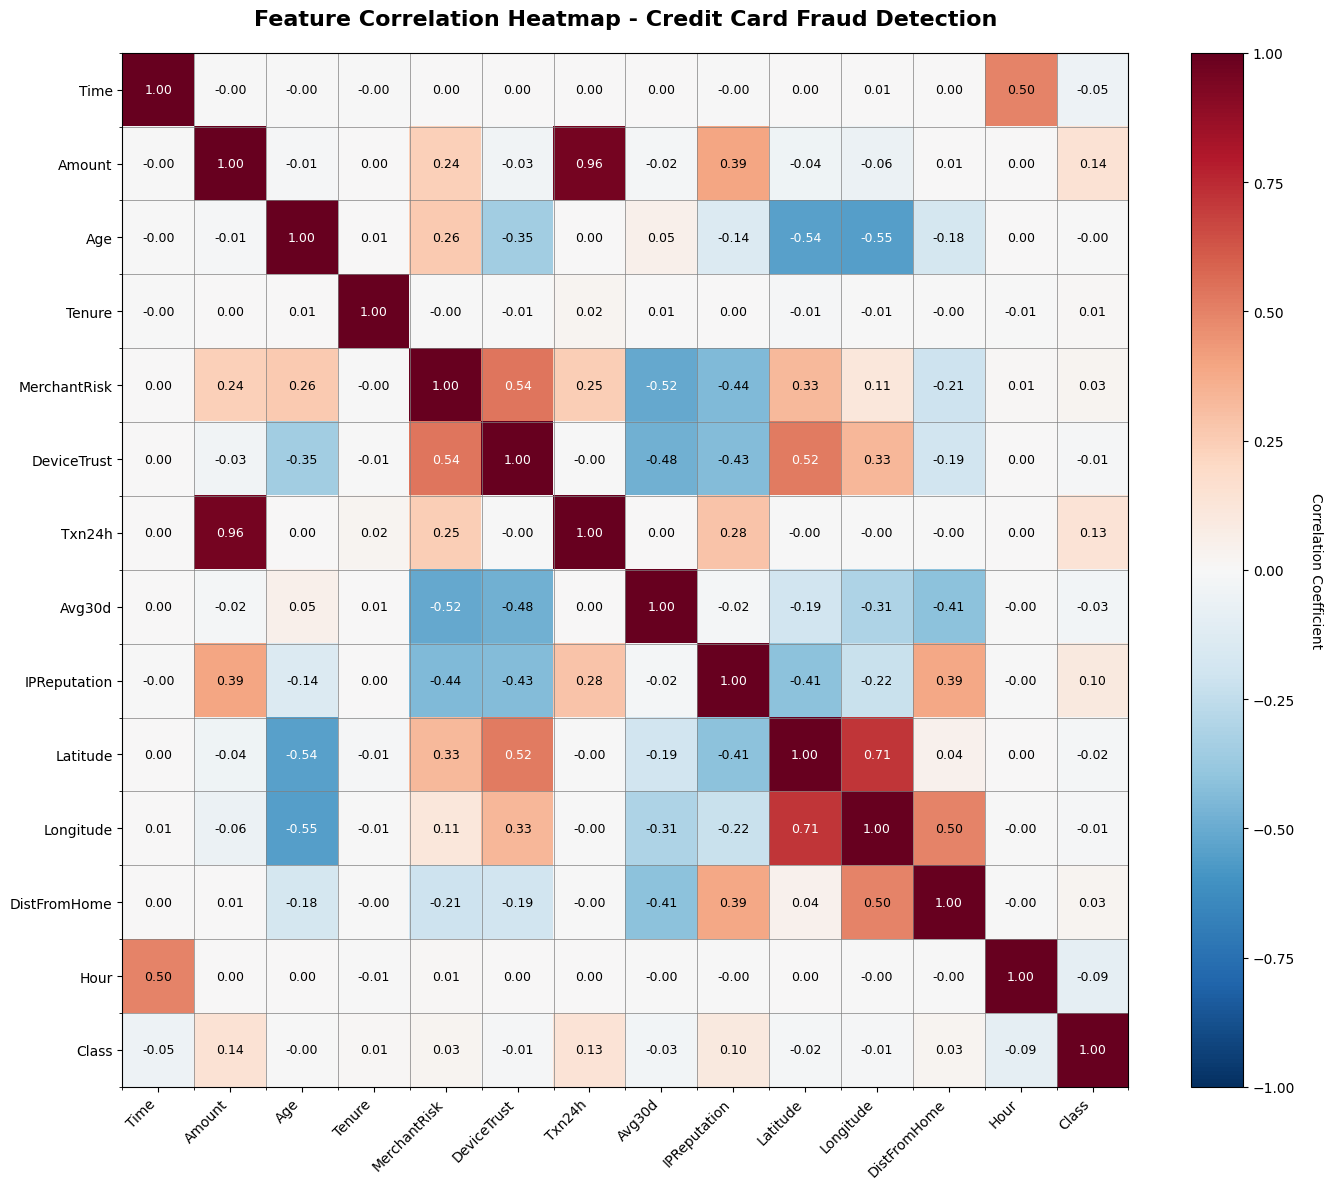

=== Strongest Correlations with Fraud (Class) ===

Top 5 positive correlations with fraud:
Amount          0.143570
Txn24h          0.134948
IPReputation    0.099046
DistFromHome    0.031068
MerchantRisk    0.028271
Name: Class, dtype: float64

Top 5 negative correlations with fraud:
Hour        -0.092281
Time        -0.051095
Avg30d      -0.028483
Latitude    -0.019562
Longitude   -0.012206
Name: Class, dtype: float64


In [6]:
# Select numerical features for correlation analysis
numerical_features = ['Time', 'Amount', 'Age', 'Tenure', 'MerchantRisk', 
                     'DeviceTrust', 'Txn24h', 'Avg30d', 'IPReputation', 
                     'Latitude', 'Longitude', 'DistFromHome', 'Hour', 'Class']
# Calculate correlation matrix
corr_matrix = clean_df[numerical_features].corr()
# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 12))
# Create heatmap using matplotlib
im = ax.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
# Set ticks and labels
ax.set_xticks(np.arange(len(numerical_features)))
ax.set_yticks(np.arange(len(numerical_features)))
ax.set_xticklabels(numerical_features, rotation=45, ha='right')
ax.set_yticklabels(numerical_features)
# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)
# Add correlation values as text annotations
for i in range(len(numerical_features)):
    for j in range(len(numerical_features)):
        value = corr_matrix.iloc[i, j]
        # Use white text for dark backgrounds, black for light
        text_color = 'white' if abs(value) > 0.5 else 'black'
        text = ax.text(j, i, f'{value:.2f}', ha='center', va='center', 
                      color=text_color, fontsize=9)
# Set title and layout
ax.set_title('Feature Correlation Heatmap - Credit Card Fraud Detection', 
             fontsize=16, fontweight='bold', pad=20)
# Add grid for better readability
ax.set_xticks(np.arange(len(numerical_features) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(numerical_features) + 1) - 0.5, minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig(f"{domino_artifact_dir}/correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()
# Print strongest correlations with fraud
print("=== Strongest Correlations with Fraud (Class) ===")
fraud_corr = corr_matrix['Class'].drop('Class').sort_values(key=abs, ascending=False)
print("\nTop 5 positive correlations with fraud:")
print(fraud_corr[fraud_corr > 0].head())
print("\nTop 5 negative correlations with fraud:")
print(fraud_corr[fraud_corr < 0].head())

### Transaction Amount Distribution by Class (Fraud vs Non-Fraud)

This plot compares the distribution of transaction amounts between legitimate and fraudulent transactions. It helps identify if fraudsters tend to target specific transaction amounts - for example, if fraud is more common in small transactions (to avoid detection) or large transactions (for maximum gain).

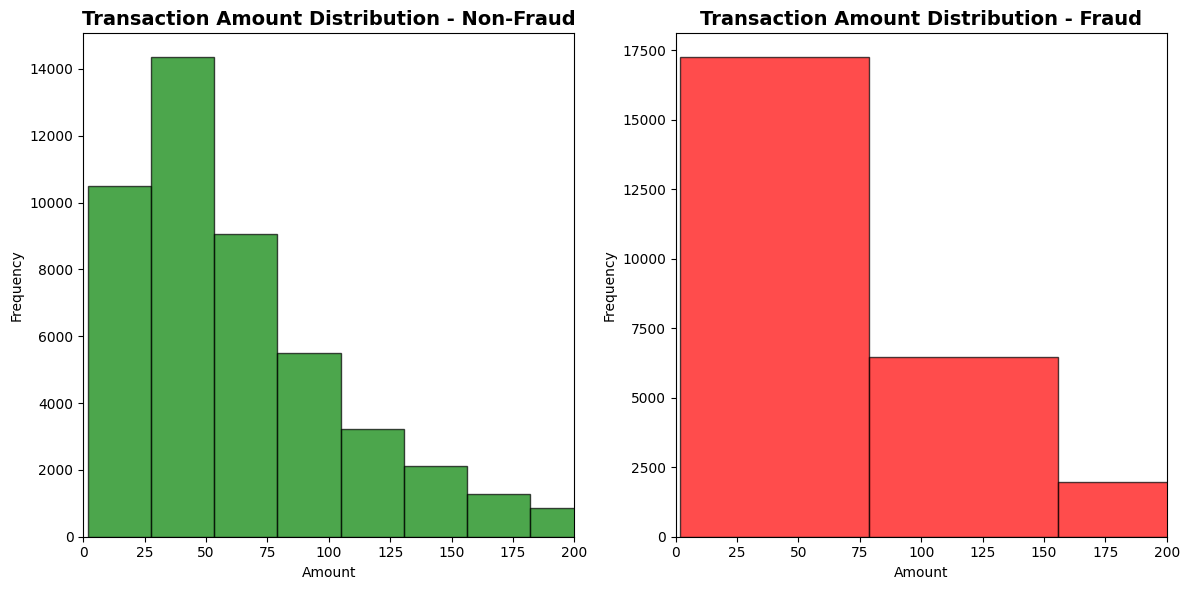

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
clean_df[clean_df['Class'] == 0]['Amount'].plot(kind='hist', bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Transaction Amount Distribution - Non-Fraud', fontsize=14, fontweight='bold')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.xlim(0, 200)  # Limiting for better visualization
plt.subplot(1, 2, 2)
clean_df[clean_df['Class'] == 1]['Amount'].plot(kind='hist', bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title('Transaction Amount Distribution - Fraud', fontsize=14, fontweight='bold')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.xlim(0, 200)  # Limiting for better visualization
plt.tight_layout()
plt.savefig(f"{domino_artifact_dir}/amount_distribution_by_class.png", dpi=300, bbox_inches='tight')
plt.show()

### Fraud Rate by Hour of Day

This bar chart shows the percentage of fraudulent transactions occurring at each hour of the day. It reveals temporal patterns in fraudulent activity, helping identify peak fraud hours when extra vigilance or real-time monitoring might be needed.

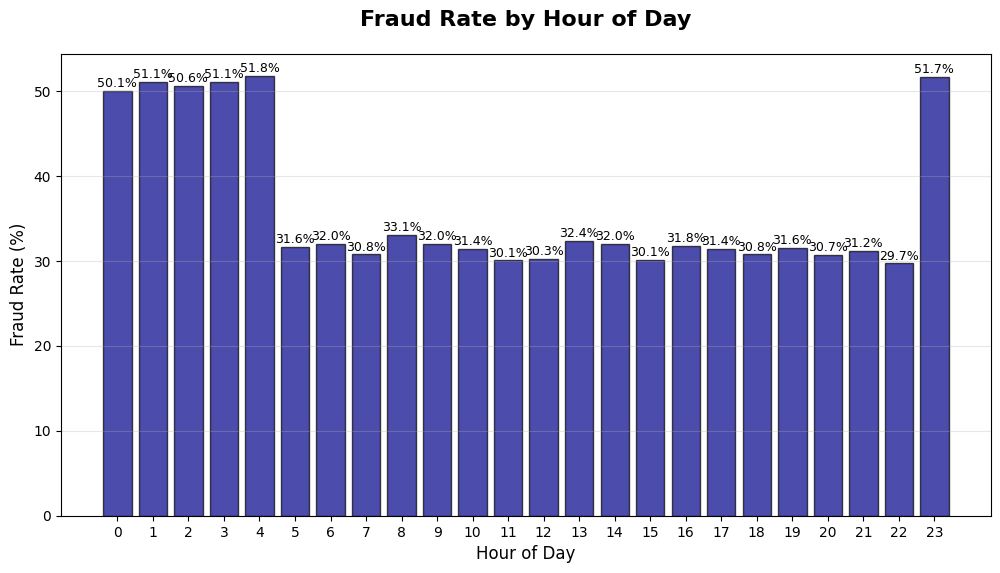

Peak fraud hour: 4:00 with 51.82% fraud rate
Lowest fraud hour: 22:00 with 29.72% fraud rate


In [8]:
fraud_by_hour = clean_df.groupby('Hour')['Class'].agg(['mean', 'count'])
fraud_by_hour['fraud_rate_pct'] = fraud_by_hour['mean'] * 100
plt.figure(figsize=(12, 6))
bars = plt.bar(fraud_by_hour.index, fraud_by_hour['fraud_rate_pct'], 
                color='darkblue', alpha=0.7, edgecolor='black')
# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
plt.title('Fraud Rate by Hour of Day', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Fraud Rate (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(0, 24))
plt.savefig(f"{domino_artifact_dir}/fraud_rate_by_hour.png", dpi=300, bbox_inches='tight')
plt.show()
# Print summary statistics
print(f"Peak fraud hour: {fraud_by_hour['fraud_rate_pct'].idxmax()}:00 with {fraud_by_hour['fraud_rate_pct'].max():.2f}% fraud rate")
print(f"Lowest fraud hour: {fraud_by_hour['fraud_rate_pct'].idxmin()}:00 with {fraud_by_hour['fraud_rate_pct'].min():.2f}% fraud rate")


### Top 10 Features Correlation with Fraud

This horizontal bar chart displays the features most strongly correlated (positively or negatively) with fraudulent transactions. Features with high positive correlation (green bars) increase with fraud likelihood, while negative correlations (red bars) indicate features that decrease when fraud is present, helping prioritize which variables to focus on in fraud detection models.

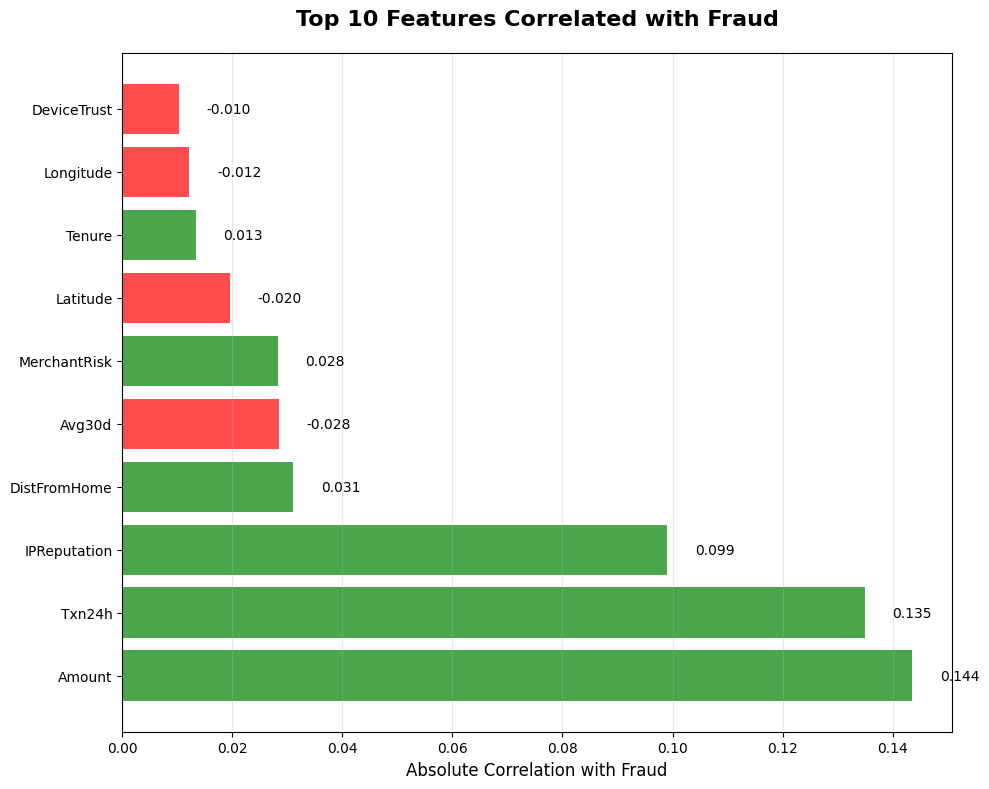

In [9]:
numeric_cols = ['Amount', 'Age', 'Tenure', 'MerchantRisk', 'DeviceTrust', 
                'Txn24h', 'Avg30d', 'IPReputation', 'Latitude', 'Longitude', 
                'DistFromHome']
correlations = clean_df[numeric_cols + ['Class']].corr()['Class'].drop('Class')
top_correlations = correlations.abs().sort_values(ascending=False).head(10)
# Create horizontal bar plot
plt.figure(figsize=(10, 8))
colors = ['red' if corr < 0 else 'green' for corr in correlations[top_correlations.index]]
bars = plt.barh(range(len(top_correlations)), top_correlations.values, color=colors, alpha=0.7)
# Add value labels
for i, (idx, val) in enumerate(top_correlations.items()):
    actual_corr = correlations[idx]
    plt.text(val + 0.005, i, f'{actual_corr:.3f}', va='center')
plt.yticks(range(len(top_correlations)), top_correlations.index)
plt.xlabel('Absolute Correlation with Fraud', fontsize=12)
plt.title('Top 10 Features Correlated with Fraud', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{domino_artifact_dir}/top_features_correlation.png", dpi=300, bbox_inches='tight')
plt.show()

### Fraud Analysis by Merchant Category and Transaction Type

This four-panel visualization breaks down fraud rates across different categorical variables:
- Merchant Category: Shows which types of merchants (electronics, gas, etc.) experience the highest fraud rates
- Transaction Type: Reveals whether purchases, transfers, or other transaction types are more vulnerable to fraud
- Device Type: Indicates if certain devices (mobile, desktop) are preferred by fraudsters
- Channel Distribution: Shows the overall volume distribution across different payment channels

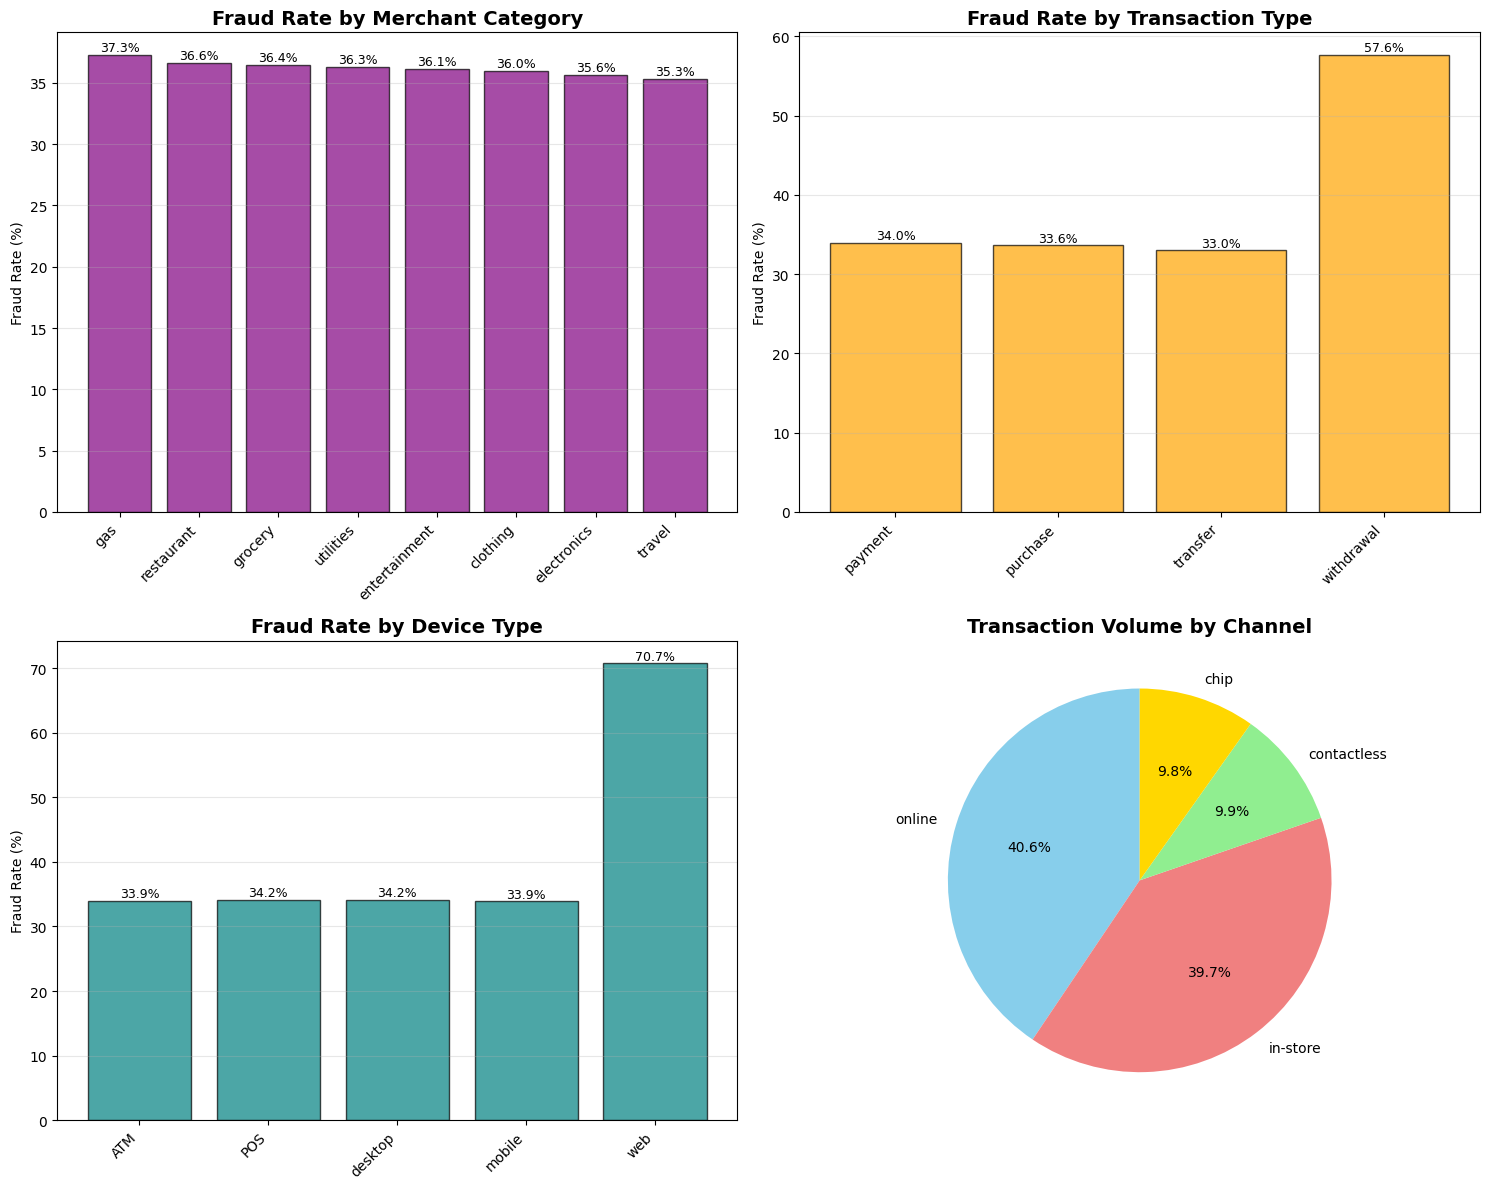


=== Fraud Analysis Summary ===

Highest fraud merchant category: gas (37.26%)
Highest fraud transaction type: withdrawal (57.63%)
Highest fraud device type: web (70.74%)


In [10]:
# Create a figure with subplots for categorical analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# 1. Fraud rate by Merchant Category
ax1 = axes[0, 0]
fraud_by_merchant = clean_df.groupby('MerchantCat')['Class'].agg(['mean', 'count'])
fraud_by_merchant['fraud_rate_pct'] = fraud_by_merchant['mean'] * 100
fraud_by_merchant = fraud_by_merchant.sort_values('fraud_rate_pct', ascending=False)
bars1 = ax1.bar(range(len(fraud_by_merchant)), fraud_by_merchant['fraud_rate_pct'], 
                 color='purple', alpha=0.7, edgecolor='black')
ax1.set_xticks(range(len(fraud_by_merchant)))
ax1.set_xticklabels(fraud_by_merchant.index, rotation=45, ha='right')
ax1.set_title('Fraud Rate by Merchant Category', fontsize=14, fontweight='bold')
ax1.set_ylabel('Fraud Rate (%)')
ax1.grid(axis='y', alpha=0.3)
# Add value labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
# 2. Fraud rate by Transaction Type
ax2 = axes[0, 1]
fraud_by_type = clean_df.groupby('TxType')['Class'].agg(['mean', 'count'])
fraud_by_type['fraud_rate_pct'] = fraud_by_type['mean'] * 100
bars2 = ax2.bar(range(len(fraud_by_type)), fraud_by_type['fraud_rate_pct'], 
             color='orange', alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(fraud_by_type)))
ax2.set_xticklabels(fraud_by_type.index, rotation=45, ha='right')
ax2.set_title('Fraud Rate by Transaction Type', fontsize=14, fontweight='bold')
ax2.set_ylabel('Fraud Rate (%)')
ax2.grid(axis='y', alpha=0.3)
# Add value labels
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
# 3. Fraud rate by Device Type
ax3 = axes[1, 0]
fraud_by_device = clean_df.groupby('DeviceType')['Class'].agg(['mean', 'count'])
fraud_by_device['fraud_rate_pct'] = fraud_by_device['mean'] * 100
bars3 = ax3.bar(range(len(fraud_by_device)), fraud_by_device['fraud_rate_pct'], 
                color='teal', alpha=0.7, edgecolor='black')
ax3.set_xticks(range(len(fraud_by_device)))
ax3.set_xticklabels(fraud_by_device.index, rotation=45, ha='right')
ax3.set_title('Fraud Rate by Device Type', fontsize=14, fontweight='bold')
ax3.set_ylabel('Fraud Rate (%)')
ax3.grid(axis='y', alpha=0.3)
# Add value labels
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
# 4. Transaction volume by channel
ax4 = axes[1, 1]
channel_counts = clean_df['Channel'].value_counts()
colors_pie = ['skyblue', 'lightcoral', 'lightgreen', 'gold'][:len(channel_counts)]
wedges, texts, autotexts = ax4.pie(channel_counts.values, labels=channel_counts.index, 
                                    autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax4.set_title('Transaction Volume by Channel', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{domino_artifact_dir}/categorical_fraud_analysis.png", dpi=300, bbox_inches='tight')
plt.show()
# Print summary statistics
print("\n=== Fraud Analysis Summary ===")
print(f"\nHighest fraud merchant category: {fraud_by_merchant.index[0]} ({fraud_by_merchant['fraud_rate_pct'].iloc[0]:.2f}%)")
print(f"Highest fraud transaction type: {fraud_by_type['fraud_rate_pct'].idxmax()} ({fraud_by_type['fraud_rate_pct'].max():.2f}%)")
print(f"Highest fraud device type: {fraud_by_device['fraud_rate_pct'].idxmax()} ({fraud_by_device['fraud_rate_pct'].max():.2f}%)")


## Save Dataframe to Domino Dataset 

**Domino Datasets** provide high-performance, versioned, and structured filesystem storage in Domino. You can use Datasets to build multiple curated collections of data in one project and share them with your collaborators to use in their projects. Likewise, you can mount Datasets from other projects in your own project if they are shared with you. You can modify the contents of a Dataset through the Domino application or through executions.

In [11]:
clean_df.to_csv(f"{domino_dataset_dir}/{clean_filename}")
print(f"Check to see that your dataset has been recently updated at {domino_dataset_dir}/{clean_filename}")

Check to see that your dataset has been recently updated at /mnt/data/Fraud-Detection-Workshop/clean_cc_transactions.csv
